In [18]:
import os
import cv2
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import pickle


In [19]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [20]:
mixseeds_path = "data/conteos_reales_datasets/19_Result_MixSeeds(Sheet1).csv" 

# Read training data file into pandas DF
df_mixseeds = pd.read_csv(mixseeds_path, sep=',', header=0)

In [21]:
df_mixseeds.sample(5)

,id foto,negras,blancas,total,Predicho,Precisión,Obs
7,UR283773874,456,241,697,1045.0,149.928264,Marron
14,UR283776009,489,420,909,955.0,105.060506,negra
10,UR283774872,182,331,513,647.0,126.120858,negra
0,UR266296512,13,740,753,775.0,102.921647,blanca
4,UR283773175,438,192,630,463.0,73.492063,Marron


droppear la que está en rojo

In [22]:
index_to_drop = df_mixseeds[df_mixseeds['total'] == 'Volver a contar'].index
df_mixseeds = df_mixseeds.drop(index_to_drop)

In [23]:
df_mixseeds.sample(19)

,id foto,negras,blancas,total,Predicho,Precisión,Obs
6,UR283773871,403,730,1133,1020.0,90.026478,blanca
12,UR283774970,215,712,927,677.0,73.031284,blanca
3,UR266296584,300,274,574,573.0,99.825784,negra
5,UR283773186,594,378,972,705.0,72.530864,negra
13,UR283775824,512,699,1211,998.0,82.411230,blanca
2,UR266296583,120,617,737,741.0,100.542741,blanca
19,UR283775890,253,818,1071,752.0,70.214753,Marron
10,UR283774872,182,331,513,647.0,126.120858,negra
9,UR283773886_Foto_2,363,398,761,506.0,66.491459,blanca
17,UR283776067,355,663,1018,1194.0,117.288802,negra


In [24]:

# Configuración
configuration = {
    "img_size": 256,  # Tamaño de las imágenes
    "batch_size": 64,  # Tamaño del batch
    "epochs": 60,  # Número máximo de épocas
    "patience": 8,  # Paciencia para EarlyStopping
    "learning_rate": 0.001,  # Tasa de aprendizaje
    "dropout_rate": 0.5,  # Dropout
    "seed": 42  # Semilla para reproducibilidad
}


In [25]:
data_path = 'data/data_img/data_19'

# Preprocesamiento de imágenes y etiquetas
def load_images_and_labels(data, image_dir):
    images = []
    labels = []
    for index, row in data.iterrows():
        image_id = row['id foto']  
        label = row[['negras', 'blancas', 'total']].values  # Etiquetas
        image_path = os.path.join(image_dir, f"{image_id}.jpg")  # Cambiar a .jpg según corresponda
        if os.path.exists(image_path):
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (configuration["img_size"], configuration["img_size"]))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Cargar las imágenes y normalizarlas
images, labels = load_images_and_labels(df_mixseeds, data_path)
images = images / 255.0  # Normalizar entre 0 y 1

In [26]:
# Etiquetas para la predicción del total
labels_total = labels[:, 2].astype(float)

# Dividir los datos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(images, labels_total, test_size=0.2, random_state=configuration['seed'])

# Expandir dimensiones para canales
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [27]:
# Crear el modelo
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(configuration["img_size"], configuration["img_size"], 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(configuration["dropout_rate"]),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(configuration["dropout_rate"]),
    layers.Dense(1, activation='linear')  # Salida continua para el total de semillas
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=configuration["learning_rate"]),
    loss='mean_squared_error',
    metrics=['mae']
)

In [28]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=configuration["patience"], restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=configuration["epochs"],
    batch_size=configuration["batch_size"],
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Guardar el modelo
model_save_path = "modelo/seed_count_model_improved.h5"
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")

# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error: {mae}")




Epoch 1/60
1/1 [==============================] - 1s 1s/step - loss: 718910.8125 - mae: 803.0346 - val_loss: 600143.3750 - val_mae: 769.1457 - lr: 0.0010
Epoch 2/60
1/1 [==============================] - 1s 546ms/step - loss: 593152.5000 - mae: 720.8608 - val_loss: 436380.4375 - val_mae: 653.9623 - lr: 0.0010
Epoch 3/60
1/1 [==============================] - 1s 524ms/step - loss: 443482.1875 - mae: 612.2308 - val_loss: 248113.7812 - val_mae: 488.9810 - lr: 0.0010
Epoch 4/60
1/1 [==============================] - 1s 509ms/step - loss: 274110.9688 - mae: 473.0176 - val_loss: 78109.3047 - val_mae: 261.9044 - lr: 0.0010
Epoch 5/60
1/1 [==============================] - 1s 503ms/step - loss: 98640.3359 - mae: 256.1048 - val_loss: 10992.1475 - val_mae: 94.4243 - lr: 0.0010
Epoch 6/60
1/1 [==============================] - 1s 509ms/step - loss: 127026.5000 - mae: 292.2567 - val_loss: 43736.9023 - val_mae: 181.4027 - lr: 0.0010
Epoch 7/60
1/1 [==============================] - 1s 503ms/step - 

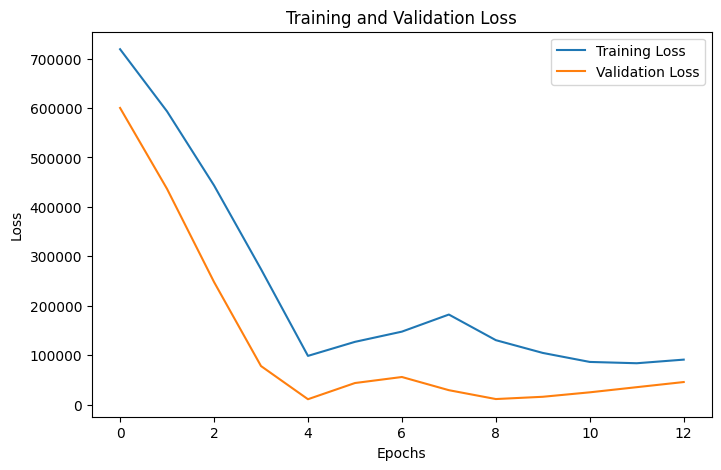

In [29]:
# Graficar la pérdida
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(loss))
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

plot_loss(history)

#### Evaluar

In [30]:

# Ruta al modelo guardado
model_path = "modelo/seed_count_model_improved.h5"

# Cargar el modelo entrenado
model = tf.keras.models.load_model(model_path)

# Configuración
configuration = {
    "img_size": 256,  # Tamaño de las imágenes
}

# Preprocesamiento de imágenes
def preprocess_image(image_path, img_size):
    """
    Preprocesa una imagen para evaluarla con el modelo.
    Args:
        image_path (str): Ruta de la imagen.
        img_size (int): Tamaño al que se debe redimensionar la imagen.
    Returns:
        np.array: Imagen preprocesada lista para evaluar.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalizar a rango [0, 1]
    return np.expand_dims(img, axis=-1)  # Agregar dimensión de canal

# Evaluar imágenes y generar resultados
def evaluate_dataset(data, image_dir, model, img_size, output_csv):
    """
    Evalúa un dataset de imágenes y genera un archivo CSV con las predicciones y los valores reales.
    Args:
        data (pd.DataFrame): DataFrame con los IDs y valores reales de las semillas.
        image_dir (str): Directorio donde se encuentran las imágenes.
        model (tf.keras.Model): Modelo cargado para evaluar.
        img_size (int): Tamaño de las imágenes.
        output_csv (str): Ruta donde se guardará el archivo CSV de resultados.
    """
    results = []
    for index, row in data.iterrows():
        image_id = row['id foto']
        true_labels = row[['negras', 'blancas', 'total']].values  # Valores reales
        image_path = os.path.join(image_dir, f"{image_id}.jpg")
        
        if os.path.exists(image_path):
            # Preprocesar la imagen
            img = preprocess_image(image_path, img_size)
            img = np.expand_dims(img, axis=0)  # Agregar dimensión de batch

            # Predecir el total de semillas
            predicted_total = model.predict(img, verbose=0)[0][0]

            # Guardar resultados
            results.append({
                'id foto': image_id,
                'Pred. Total': round(predicted_total),
                # 'Real Negras': int(true_labels[0]),
                # 'Real Blancas': int(true_labels[1]),
                'Real Total': int(true_labels[2]),
                'Error': abs(round(int(predicted_total)) - int(true_labels[2]))
            })
    
    # Crear DataFrame de resultados y guardar en CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Resultados guardados en: {output_csv}")

# Ruta de las imágenes y dataset
image_dir = 'data/data_img/data_19'  # Directorio donde están las imágenes
output_csv = "resultados/resultados_predicciones.csv"  # Ruta del CSV de salida

# Evaluar dataset
evaluate_dataset(df_mixseeds, image_dir, model, configuration['img_size'], output_csv)


Resultados guardados en: resultados_predicciones.csv
